### hi_res_grid_tiff2nc_fitler
Script to read in `.tif` files exported from Global Mapper and write `.nc` files

The input `.tif` files were exported in UTM Zone 18N, NAVD88 coordinates for a specific bounding box
outlining a high-resolution region that CRS and CAH chose on June 4, 2021. The GM project is
`..\proj\2019_DorianOBX\High_res_grid.gmw`.  

Coordinates for the elevation matrices were converted to island coordinates and lat/lon using routines in `CoreBx_funcs`.

This version processes the files to:
* correct biases (global offsets in elevation)
* smooth
* fill holes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
from scipy import interpolate, signal
import netCDF4 as nc
from CoreBx_funcs import *
import pickle

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

%matplotlib inline

vegmap= cm.get_cmap('YlGn')
vegmap.set_bad(color='darkgray')

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\astropy\config\configuration.py:557: ConfigurationMissingWarning: Configuration defaults will be used due to FileNotFoundError:2 on None
  warn(ConfigurationMissingWarning(msg))


#### Source files

These files were exported from the Global Mapper project for the same bounding box 

In [2]:
fdir = "C:/crs/proj/2021_hi_res_grid/"
fnames = ("2019-08-30_1m_DEM_4d_hr.tif",
          "2019-09-12-13_1m_DEM_4d_hr.tif",
          "2019-10-11_1m_DEM_4d_hr.tif",
          "2019-11-26_1m_DEM_4d_hr.tif",
          "2019_NCMP_gnd_50_1m_hr.tif",
          "2019_NCMP_1st95_1m_hr.tif",
          "2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr.tif",
)
mnames = ("Aug SfM",
          "Sep SfM",
          "Oct SfM",
          "Nov SfM",
          "Nov Lidar Gnd50",
          "Nov Lidar First95",
          "Nov Lidar Diff")

fnnc = 'C:/crs/proj/2019_DorianOBX/NCEI_gridded_bathy/morehead_city_13_navd88_2011.nc'
# ds = nc.Dataset(fnnc)
# print(ds)

# dimension array for elevations - hardwired for size of tif files and number of maps
z = np.nan*np.ones((7, 1685, 1627))
print(np.shape(z))

(7, 1685, 1627)


#### Load the `.tif` files and put in 3D array *z*

In [3]:
dslist=[]
for i, fn in enumerate(fnames):
    iswarned = False
    fp = fdir+fn
    print(i, fp)

    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fp)

    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)

    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z[i,:,:] = np.flipud(np.squeeze(da.values))
  

0 C:/crs/proj/2021_hi_res_grid/2019-08-30_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
1 C:/crs/proj/2021_hi_res_grid/2019-09-12-13_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
2 C:/crs/proj/2021_hi_res_grid/2019-10-11_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
3 C:/crs/proj/2021_hi_res_grid/2019-11-26_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
4 C:/crs/proj/2021_hi_res_grid/2019_NCMP_gnd_50_1m_hr.tif
(1685,) (1627,) (1, 1685, 1627)
5 C:/crs/proj/2021_hi_res_grid/2019_NCMP_1st95_1m_hr.tif
(1685,) (1627,) (1, 1685, 1627)
6 C:/crs/proj/2021_hi_res_grid/2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr.tif
(1685,) (1627,) (1, 1685, 1627)


#### Replace missing values with NaNs

In [4]:
# Missing values come through as -32767 
ibadz = np.where(z<=-32767.)
z[ibadz] = np.nan

#### Correct for biases
The first four for the SfM maps were based on early "stable point" analyses.
Offsets for the Lidar surfaces are based on analysis of a profile of points across the dune and beach on the Nov SfM and Lidar maps. Profile is in `../proj/2021_hi_res_grid/lidargnd_sfm_profile.csv`

For bare, sandy regions:
Oct LidarGnd is lower than oct SfM by 14.6 cm.
Oct LidarGnd is lower that Oct Lidar canopy by 7.3 cm.

See `hi_res_offset_dunex_lidar_v_sfm.ipynb`
```
print("mean sfm minus lidar (corrected)", np.nanmean(zsfm-(zlidar+0.146)))
print("mean canopy minus lidar (corrected)", np.nanmean((zcanopy-0.073+0.146)-(zlidar+0.146)))
print("mean sfm minus canopy (corrected)", np.nanmean(zsfm-(zcanopy-0.073+0.146)))
```
gives
```
mean sfm minus lidar 0.14645173745173745
mean canopy minus ground 0.07325868725868727
mean sfm minus canopy 0.07267177033492823
```
Have to add these SfM v. Lidar differences to the offset for October

In [5]:
# offsets to be *added* to elevations for [Aug, Sep, Oct, Nov, lidar_gnd, lidar_canopy, veg_height]
offset = np.array([-0.022233, 0.002373, 0.004543, 0.015317, 0., 0., 0.])
offset[4] = 0.146+offset[2]
offset[5] = offset[4]-0.073
offset[6] = -0.073
print('Offsets to be applied:',offset)
for i in range(0,7):
    print(i, offset[i])
    z[i,:,:] = z[i,:,:]+offset[i]

Offsets to be applied: [-0.022233  0.002373  0.004543  0.015317  0.150543  0.077543 -0.073   ]
0 -0.022233
1 0.002373
2 0.004543
3 0.015317
4 0.15054299999999998
5 0.07754299999999999
6 -0.073


#### Make a grid
Convert from UTM to island coordinates and lat/lon  

Is meshgrid where the coordinates get flipped (see query about netCDF below)

In [6]:
east, north = np.meshgrid(x,y)
xisl, yisl = UTM2Island(east,north)
lond, latd = UTM2LatLon(east, north)

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


#### Process the DEMs as follows:

* Replace NaNs in Oct Lidar Gnd with data from SfM October grid
* Reverse the process: replace NaNs in Sfm with Lidar

In [7]:
zOctSfM = z[2,:,:]
zOctLidar = z[4,:,:]

# fill holes in Lidar with SfM
zOctLidar[np.isnan(zOctLidar)]=zOctSfM[np.isnan(zOctLidar)]
# fill holes in SfM with Lidar
zOctSfM[np.isnan(zOctSfM)]=zOctLidar[np.isnan(zOctSfM)]

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


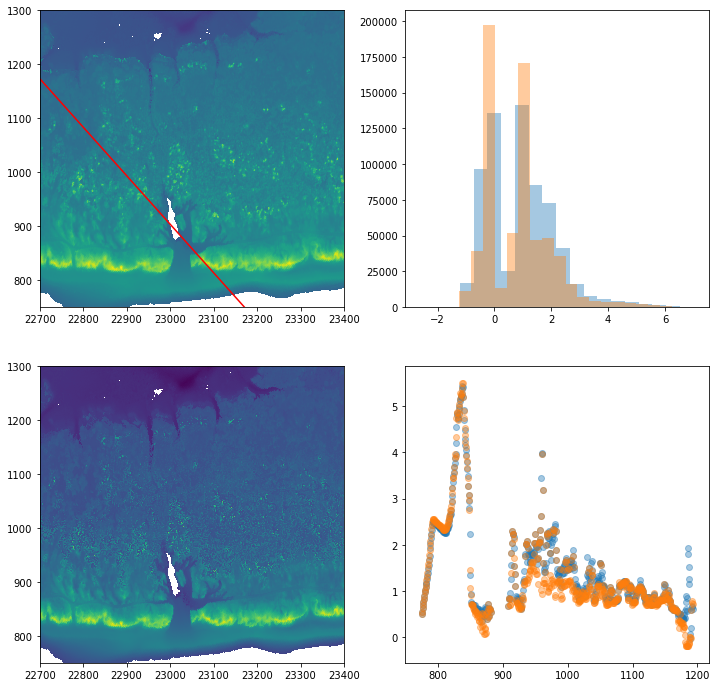

In [8]:
def plotgrid(x,y,z,z2):
    iz = np.argwhere(x==23000)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.pcolormesh(x,y,z)
    plt.plot(x[650,:],y[650,:],c='r')
    plt.xlim((22700,23400))
    plt.ylim((750,1300))
    plt.subplot(222)
    _ = plt.hist(np.ravel(z), bins=20, histtype='stepfilled', alpha=0.4)
    _ = plt.hist(np.ravel(z2), bins=20, histtype='stepfilled', alpha=0.4)
    plt.subplot(223)
    plt.pcolormesh(x,y,z2)
    plt.xlim((22700,23400))
    plt.ylim((750,1300))
    plt.subplot(224)
    plt.scatter(y[650,:],z[650,:], alpha=0.4)
    plt.scatter(y[650,:],z2[650,:], alpha=0.4)


plotgrid(xisl,yisl,zOctSfM,zOctLidar)

13.0


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


3.0


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


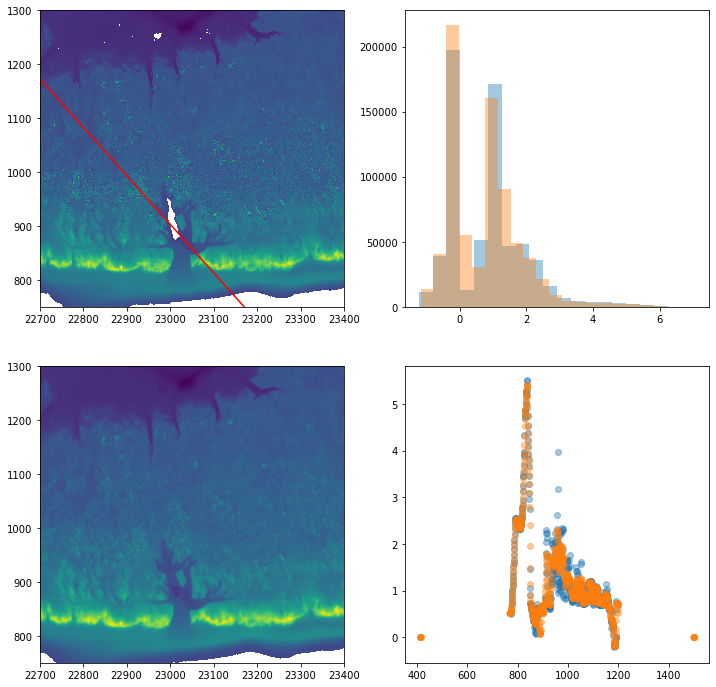

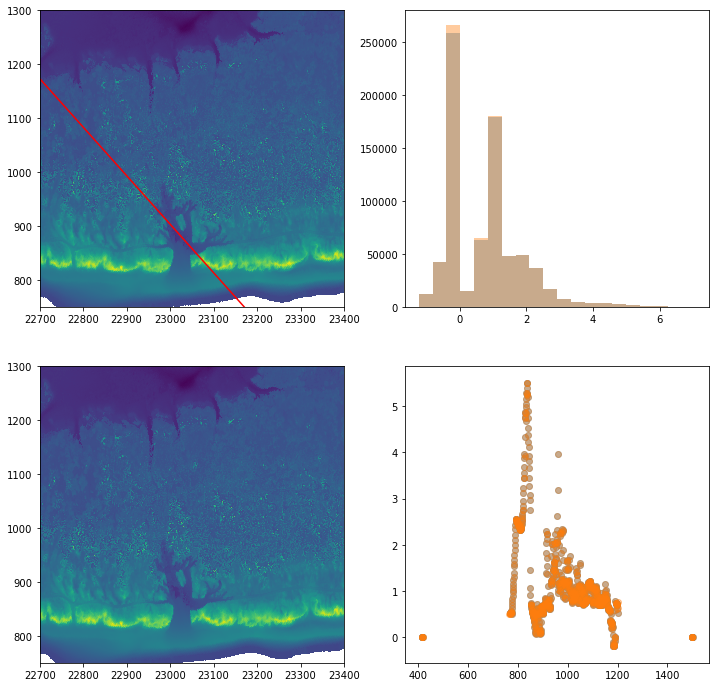

In [9]:

# astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors

# smallest kernel that will fill the gully
kernel = Gaussian2DKernel(x_stddev=1.5)
print(np.sqrt(np.size(kernel)))
zOctLidarSmooth13 = convolve(zOctLidar, kernel)

plotgrid(xisl,yisl,zOctLidar,zOctLidarSmooth13)

# fill holes in Lidar with smoothed lidar
zOctLidar[np.isnan(zOctLidar)]=zOctLidarSmooth13[np.isnan(zOctLidar)]

kernel = Gaussian2DKernel(x_stddev=.25)
print(np.sqrt(np.size(kernel)))
zOctLidarSmooth3 = convolve(zOctLidar, kernel)

plotgrid(xisl,yisl,zOctLidar,zOctLidarSmooth3)


#### Write the coordinate meshes and elevation maps to netCDF

I don't understand why I had to use `var[:,:] = var.T` to get this to work. I hope that does not mess up the `.nc` file. Maybe it was the `meshgrid` command.

In [10]:
fno = 'C:/crs/proj/2019_DorianOBX/WayneWright_flights/CoreBx/NCBx_hi_res_adj_smoothed.nc'
dso = nc.Dataset(fno, 'w', format='NETCDF4')

#time = dso.createDimension('time', None)
xi_rho = dso.createDimension('xi_rho', 1685)
eta_rho = dso.createDimension('eta_rho', 1627)

xi = dso.createVariable('xi', np.float32, (('eta_rho','xi_rho')))
yi = dso.createVariable('yi', np.float32, (('eta_rho','xi_rho')))
xi.units = 'm'
xi.long_name = 'Along-island coordinate'
yi.units = 'm'
yi.long_name = 'Cross-island coordinate'

xi[:,:]=xisl.T
yi[:,:] = yisl.T

lon = dso.createVariable('lon', 'f4', ('eta_rho','xi_rho'))
lat = dso.createVariable('lat', 'f4', ('eta_rho','xi_rho'))
lon.units = 'degrees N'
lat.units = 'degrees E'
lon.crs = 'epsg:4326'
lat.crs = 'epsg:4326'

lon[:,:] = lond.T
lat[:,:] = latd.T

easting = dso.createVariable('easting', 'f4', ('eta_rho','xi_rho'))
northing = dso.createVariable('northing', 'f4', ('eta_rho','xi_rho'))
easting.units = 'm UTM18N'
northing.units = 'm UTM18N'
easting.crs = 'epsg:26918'
northing.crs = 'epsg:26918'

easting[:,:] = east.T
northing[:,:] = north.T

zAug = dso.createVariable('zAug', 'f4', (('eta_rho','xi_rho')))
zAug.units = 'm NAVD88'
zAug.long_name = '2019-08-30_1m_DEM_4d_hr'
zAug[:,:] = z[0,:,:].T

zSep = dso.createVariable('zSep', 'f4', (('eta_rho','xi_rho')))
zSep.units = 'm NAVD88'
zSep.long_name = '2019-09-12-13_1m_DEM_4d_hr'
zSep[:,:] = z[1,:,:].T

zOct = dso.createVariable('zOct', 'f4', (('eta_rho','xi_rho')))
zOct.units = 'm NAVD88'
zOct.long_name = '2019-10-11_1m_DEM_4d_hr'
zOct[:,:] = z[2,:,:].T

zNov = dso.createVariable('zNov', 'f4', (('eta_rho','xi_rho')))
zNov.units = 'm NAVD88'
zNov.long_name = '2019-11-26_1m_DEM_4d_hr'
zNov[:,:] = z[3,:,:].T

zOctLidarGnd = dso.createVariable('zOctLidarGnd', 'f4', (('eta_rho','xi_rho')))
zOctLidarGnd.units = 'm NAVD88'
zOctLidarGnd.long_name = '2019_NCMP_gnd_50_1m_hr'
zOctLidarGnd[:,:] = z[4,:,:].T

zOctLidarFirst = dso.createVariable('zOctLidarFirst', 'f4', (('eta_rho','xi_rho')))
zOctLidarFirst.units = 'm NAVD88'
zOctLidarFirst.long_name = '2019_NCMP_1st95_1m_hr'
zOctLidarFirst[:,:] = z[5,:,:].T

zOctLidarVeg = dso.createVariable('zOctLidarVeg', 'f4', (('eta_rho','xi_rho')))
zOctLidarVeg.units = 'm NAVD88'
zOctLidarVeg.long_name = '2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr'
zOctLidarVeg[:,:] = z[6,:,:].T

zOctLidarS13 = dso.createVariable('zOctLidarS13', 'f4', (('eta_rho','xi_rho')))
zOctLidarS13.units = 'm NAVD88'
zOctLidarS13.long_name = '2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr'
zOctLidarS13[:,:] = zOctLidarSmooth13.T

zOctLidarS03 = dso.createVariable('zOctLidarS03', 'f4', (('eta_rho','xi_rho')))
zOctLidarS03.units = 'm NAVD88'
zOctLidarS03.long_name = '2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr'
zOctLidarS03[:,:] = zOctLidarSmooth3.T

dso.close()